In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import time
import numpy as np

from nltk.tokenize import TweetTokenizer

### Twitter chat corpus preprocessing

dataset source: https://github.com/Marsan-Ma/chat_corpus

In [2]:
def sentence_to_ids(sentence, dictionary):
    """
    Transform sentence into ids and record new words
        sentence: [word_0, word_1, ...]
        dictionary: {word: [id, frequency]}
    """
    ids = []
    for i in range(len(sentence)):
        # strip hashtag's #
        if sentence[i][0] == "#":
            sentence[i] = sentence[i][1:]

        if sentence[i] not in dictionary:
            dictionary[sentence[i]] = [len(dictionary), 0]

        # count word frequency
        dictionary[sentence[i]][1] += 1

        ids.append(dictionary[sentence[i]][0])
    
    return sentence, ids


def tokenize_and_build_dictionary(sentences, print_every=100000):
    """
    NLTK Tweet: Tokenizations for training data, build a dictionary
        sentences: [sentence_0, sentence_1, ...]
    Returns:
        data: list of {message:[...], m_ids:[...], response:[...], r_ids:[...]}
        dictionary: {word: [id, frequency]}
    """
    twtknzr = TweetTokenizer(reduce_len=True, strip_handles=True)
    data = []
    dictionary = {}

    # Build dictionary
    st = time.time()
    for i in range(0, len(sentences), 2):
        pair = {}
        message = twtknzr.tokenize(sentences[i])
        response = twtknzr.tokenize(sentences[i + 1])

        # transform text into token_id sequence
        pair["message"], pair["m_ids"] = sentence_to_ids(message, dictionary)
        pair["response"], pair["r_ids"] = sentence_to_ids(response, dictionary)

        if i % print_every == 0:
            print("Processed {} sentences, used {:.4f} seconds.".format(
                  i, time.time() - st))

        data.append(pair)

    return data, dictionary

In [4]:
df = pd.read_csv("twitter_en_big.txt", header=None, sep="\t")

In [5]:
data, dictionary = tokenize_and_build_dictionary(df[0].tolist())

Processed 0 sentences, used 0.0006 seconds.
Processed 100000 sentences, used 6.8714 seconds.
Processed 200000 sentences, used 13.2371 seconds.
Processed 300000 sentences, used 20.8553 seconds.
Processed 400000 sentences, used 28.4578 seconds.
Processed 500000 sentences, used 35.2528 seconds.
Processed 600000 sentences, used 42.3493 seconds.
Processed 700000 sentences, used 49.5808 seconds.
Processed 800000 sentences, used 56.4027 seconds.
Processed 900000 sentences, used 62.9982 seconds.
Processed 1000000 sentences, used 70.3672 seconds.
Processed 1100000 sentences, used 77.9817 seconds.
Processed 1200000 sentences, used 84.6329 seconds.
Processed 1300000 sentences, used 91.7561 seconds.
Processed 1400000 sentences, used 99.6297 seconds.
Processed 1500000 sentences, used 106.4259 seconds.
Processed 1600000 sentences, used 113.4650 seconds.
Processed 1700000 sentences, used 120.1971 seconds.
Processed 1800000 sentences, used 128.0018 seconds.
Processed 1900000 sentences, used 134.6044 s

In [6]:
total_words = sum([len(d["m_ids"]) + len(d["r_ids"]) for d in data])
dict_size = len(dictionary)

print("Total words: {}; Vocabulary size: {}".format(total_words, dict_size))

Total words: 78896214; Vocabulary size: 490844


#### Select Vocabulary Size Threshold

In [7]:
# sort dictionary by word frequency
word_freq = [(dictionary[key][1], key) for key in dictionary.keys()]
words_sort_by_freq = sorted(word_freq, reverse=True)
freq = np.asarray(words_sort_by_freq)[:, 0].astype(np.int32)

words_sort_by_freq[:200]

[(3427659, '.'),
 (2149626, 'the'),
 (1679820, ','),
 (1653380, 'to'),
 (1522926, 'i'),
 (1414138, 'a'),
 (1224043, '!'),
 (1091332, 'you'),
 (1016107, 'and'),
 (973584, 'is'),
 (930598, '?'),
 (927294, 'of'),
 (822498, 'in'),
 (737845, 'for'),
 (736758, 'it'),
 (698561, 'that'),
 (591339, 'this'),
 (537695, 'on'),
 (511206, '"'),
 (481721, 'my'),
 (417829, 'be'),
 (415003, 'not'),
 (413289, 'but'),
 (392080, 'are'),
 (391168, 'have'),
 (379540, 'was'),
 (377057, 'so'),
 (368757, 'with'),
 (353307, 'me'),
 (311717, 'just'),
 (310173, '...'),
 (303278, 'like'),
 (301573, 'we'),
 (294072, 'at'),
 (288788, 'your'),
 (287566, 'what'),
 (287371, 'he'),
 (281890, 'they'),
 (276753, "i'm"),
 (272696, 'if'),
 (272233, 'all'),
 (266775, ':'),
 (260933, "it's"),
 (245940, 'about'),
 (245561, '&'),
 (239664, 'do'),
 (234406, '…'),
 (228516, 'as'),
 (222962, 'trump'),
 (218463, 'no'),
 (211724, 'out'),
 (210307, "don't"),
 (207928, 'up'),
 (205857, 'can'),
 (204347, 'will'),
 (202016, 'get'),
 (20

In [8]:
# set the vocabulary size threshold
num_keep_words = 50000

# number of words that will be dropped
num_words_drop = freq[num_keep_words:].sum()
percent_drop = num_words_drop / total_words

info = "Keep the most frequent {} words will drop {} tokens "
info += "which is {:.3f} percent."
print(info.format(num_keep_words, num_words_drop, 100 * percent_drop))

words_sort_by_freq[num_keep_words]

Keep the most frequent 50000 words will drop 1066692 tokens which is 1.352 percent.


(19, 'reputed')

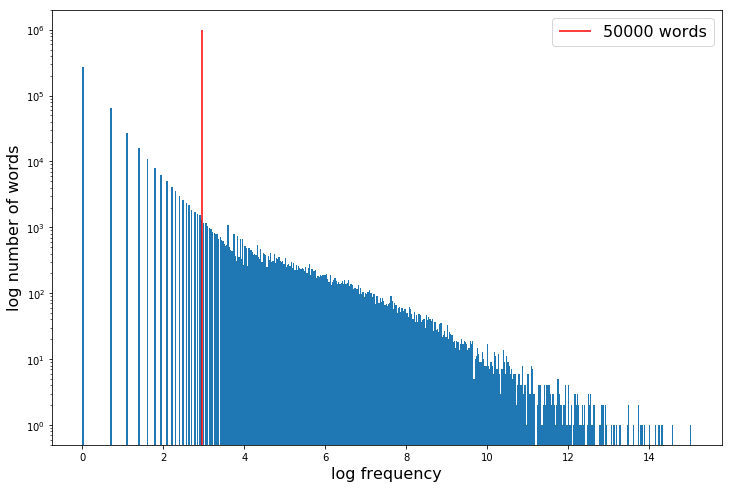

In [9]:
log_freq = np.log(freq)
plt.figure(figsize=(12, 8))
plt.hist(log_freq, bins=500, log=True)

threshold = np.log(words_sort_by_freq[num_keep_words][0])
plt.vlines(x=threshold, colors="r", ymin=0, ymax=10**6,
           label="{} words".format(num_keep_words))
plt.xlabel("log frequency", fontsize=16)
plt.ylabel("log number of words", fontsize=16)
plt.legend(fontsize=16)

#### Process sentences by the new dictionary with predefined vocabulary size

In [10]:
def process_sentence(sentence, dictionary):
    """
    Process sentence with the new dictionary
        1. Drop words not in the dictionary
        2. Return a new list of word ids
    """
    processed_sent = []
    processed_ids = []
    for word in sentence:
        if dictionary.get(word) is not None:
            processed_sent.append(word)
            processed_ids.append(dictionary[word])

    return processed_sent, processed_ids

In [11]:
# build new dictionary
dictionary = {}
for index, freq_word in enumerate(words_sort_by_freq[:num_keep_words]):
    dictionary[freq_word[1]] = index

In [12]:
for i in range(len(data)):
    data[i]["message"], data[i]["m_ids"] = process_sentence(
        data[i]["message"], dictionary)

    data[i]["response"], data[i]["r_ids"] = process_sentence(
        data[i]["response"], dictionary)

p_total_words = sum([len(d["m_ids"]) + len(d["r_ids"]) for d in data])
p_dict_size = len(dictionary)

print("Processed total words: {}; New vocabulary size: {}".format(
      p_total_words, p_dict_size))

Processed total words: 77829522; New vocabulary size: 50000


#### Export as processed files

In [13]:
def to_output_form(token_list):
    """
    Transform data into a string output format
    """
    output = " ".join(np.array(token_list, dtype=str).tolist())

    return output


def export_data(data):
    """
    Save data as raw text files for messages, responses and their ids
    """
    df = pd.DataFrame(data).applymap(to_output_form)

    df["message"].to_csv("twitter_message.txt", header=None, index=None)
    df["response"].to_csv("twitter_response.txt", header=None, index=None)

    df["m_ids"].to_csv("twitter_message_ids.txt", header=None, index=None)
    df["r_ids"].to_csv("twitter_response_ids.txt", header=None, index=None)

In [14]:
export_data(data)